Import Libraries

In [28]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Dataset Configuration and Class Labels

In [29]:
source_dir = "Blended malware image"
image_size = (224, 224)
batch_size = 32
epochs = 20

classes = sorted(
    d for d in os.listdir(source_dir)
    if os.path.isdir(os.path.join(source_dir, d))
)


Gather File Paths and Integer Labels

In [30]:
file_paths, labels = [], []
for label, cls in enumerate(classes):
    cls_dir = os.path.join(source_dir, cls)
    for fname in os.listdir(cls_dir):
        fpath = os.path.join(cls_dir, fname)
        if os.path.isfile(fpath):
            file_paths.append(fpath)
            labels.append(label)


Split Dataset

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels,
    test_size=0.30,
    stratify=labels,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


TF-Data Pipeline

In [32]:
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = resnet_preprocess_input(img)  # Updated preprocessing
    label = tf.one_hot(label, depth=len(classes))
    return img, label

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    return (
        ds
        .map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = make_dataset(X_train, y_train, shuffle=True).repeat()
val_ds   = make_dataset(X_val,   y_val,   shuffle=False)
test_ds  = make_dataset(X_test,  y_test,  shuffle=False)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Spatial Aggregation Vector Encoding (SAVE) Layer

In [33]:
class SpatialAggregationLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.alpha_top    = self.add_weight('alpha_top',    (1,), initializer='ones')
        self.alpha_bottom = self.add_weight('alpha_bottom', (1,), initializer='ones')
        self.alpha_left   = self.add_weight('alpha_left',   (1,), initializer='ones')
        self.alpha_right  = self.add_weight('alpha_right',  (1,), initializer='ones')
        super().build(input_shape)

    def call(self, inputs):
        t = tf.roll(inputs, -1, axis=1)
        b = tf.roll(inputs,  1, axis=1)
        l = tf.roll(inputs, -1, axis=2)
        r = tf.roll(inputs,  1, axis=2)
        return inputs \
            + self.alpha_top    * t \
            + self.alpha_bottom * b \
            + self.alpha_left   * l \
            + self.alpha_right  * r


Build ResNet50 Model with SAVE

In [34]:
def build_resnet50_model(num_classes, image_size=image_size):
    backbone = ResNet50(
        input_shape=(*image_size, 3),
        include_top=False,
        weights='imagenet'
    )

    x = backbone.output
    x = SpatialAggregationLayer()(x)
    x = Flatten()(x)
    x = Dense(1000, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=backbone.input, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
        ]
    )
    return model

model = build_resnet50_model(num_classes=len(classes))
model.summary()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                              

Model Training

In [35]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('models', exist_ok=True)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/resnet50_malware_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=len(X_train) // batch_size,  # Important for .repeat()
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)

model.save('models/resnet50_malware_final.h5')


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
84/84 [==============================] - ETA: 0s - loss: 21.8399 - accuracy: 0.3717 - auc: 0.7993 - false_positives: 342.0000 - precision: 0.6624 - recall: 0.2496 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B79FA6AEE8> and will run it as-is.
Please report this to the TensorFlow team. When fil

Plot Training History

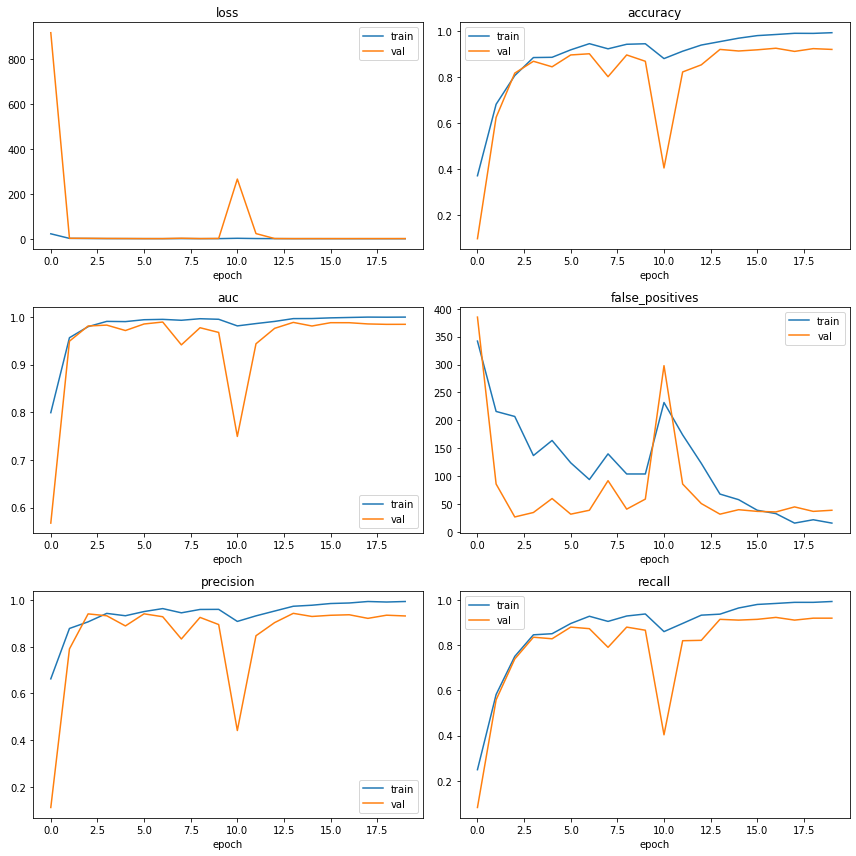

In [36]:
def plot_history(hist):
    metrics = ['loss', 'accuracy', 'auc', 'false_positives', 'precision', 'recall']
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    for idx, m in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        ax.plot(hist.history[m], label='train')
        ax.plot(hist.history[f'val_{m}'], label='val')
        ax.set_title(m)
        ax.set_xlabel('epoch')
        ax.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


Model Validation

In [37]:
val_metrics = model.evaluate(val_ds, verbose=1)
print("\nValidation set metrics:")
for name, value in zip(model.metrics_names, val_metrics):
    print(f" - {name}: {value:.4f}")


19/19 [==============================] - 29s 2s/step - loss: 0.5112 - accuracy: 0.9210 - auc: 0.9847 - false_positives: 39.0000 - precision: 0.9321 - recall: 0.9192

Validation set metrics:
 - loss: 0.5112
 - accuracy: 0.9210
 - auc: 0.9847
 - false_positives: 39.0000
 - precision: 0.9321
 - recall: 0.9192


Model Testing

In [38]:
start = time.time()
preds = model.predict(test_ds)
print(f"\nInference time on test set: {time.time() - start:.2f}s")

y_true = np.argmax(
    np.vstack([y for _, y in test_ds.unbatch()]), axis=1
)
y_pred = np.argmax(preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 39s 2s/step

Inference time on test set: 39.09s

Classification Report:

                precision    recall  f1-score   support

      Adposhel       0.91      1.00      0.95        21
         Agent       0.94      0.94      0.94        18
       Allaple       0.94      0.89      0.92        19
 Alueron.gen!J       1.00      1.00    

Model Evaluation

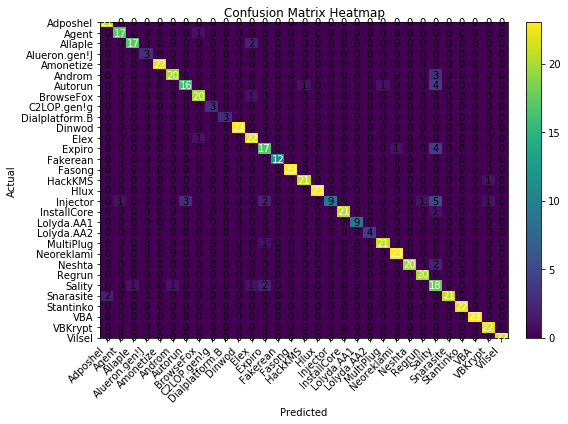

In [39]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix Heatmap')
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(fraction=0.046, pad=0.04)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(
        j, i, f"{cm[i, j]:d}",
        ha='center', va='center',
        color='white' if cm[i, j] > thresh else 'black'
    )

plt.tight_layout()
plt.show()
